In [1]:
import os
from typing import List
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from urllib.parse import urlparse, parse_qs
from dotenv import load_dotenv
import googleapiclient.discovery

In [2]:
load_dotenv()
llm = ChatOpenAI(model="gpt-4o", streaming=True)
small_llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
embedding = OpenAIEmbeddings(model="text-embedding-3-large")

In [3]:
@tool
def get_youtube_comments_for_url(youtube_url: str, max_results: int = 30) -> dict:
    """주어진 유튜브 URL에서 영상 ID를 추출하고, 그 영상의 댓글을 인기순으로 최대 30개까지 수집합니다."""
    def extract_video_id(url):
        if not url:
            return None
        parsed_url = urlparse(url)
        if parsed_url.hostname and "youtube.com" in parsed_url.hostname:
            query_string = parse_qs(parsed_url.query)
            return query_string.get("v", [None])[0]
        elif parsed_url.hostname and "youtu.be" in parsed_url.hostname:
            return parsed_url.path[1:]
        return None

    video_id = extract_video_id(youtube_url)
    if not video_id:
        return {"error": "유효한 유튜브 URL이 아닙니다."}
    
    try:
        api_key = os.getenv("YOUTUBE_API_KEY")
        youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=api_key)
        request = youtube.commentThreads().list(
            part="snippet", videoId=video_id, maxResults=100, order="relevance"
        )
        response = request.execute()
        comments = [
            item['snippet']['topLevelComment']['snippet']['textDisplay']
            for item in response['items']
        ]
        return {"video_id": video_id, "comments": comments[:max_results]}
    except Exception as e:
        return {"error": f"댓글 수집 중 에러 발생: {e}"}

In [4]:
#테스트 코드
if __name__ == "__main__":
    test_url = "https://www.youtube.com/watch?v=itJE4neqDJw"  # 원하는 영상 URL로 변경 가능

    result = get_youtube_comments_for_url(test_url)
    if "comments" in result:
        comments = result["comments"]
        print(f"\n총 {len(comments)}개의 댓글 중 상위 5개:")
        for i, comment in enumerate(comments[:5], 1):
            print(f"{i}. {comment}")
    else:
        print("에러:", result.get("error"))

C:\Users\KOSALOVE\AppData\Local\Temp\ipykernel_16640\345566190.py:5: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = get_youtube_comments_for_url(test_url)



총 30개의 댓글 중 상위 5개:
1. A fresh stretch routine for you guys! ❤️ Stretching is so important for overall body health. Find time in your day to get a quick stretch on... I promise your body will thank you. Xx - Maddie
2. as a 17yo I thought I didn&#39;t need to stretch since I&#39;m still young but oh my goodness, after finishing this video my body feels so much more fluid + less tight than usual, definitely going to try do this every morning!
3. To anyone who&#39;s reading this:<br>You are strong. You are beautiful. You are powerful. <br>Remind yourself that working out is not a punishment for what you ate, but a celebration of what your body can do!<br>I hope you have a fantastic day :))
4. When she wears her hair down, it&#39;s encouraging - it&#39;s like, ok, I bet I can handle this one! 😁
5. I NEVER stretch! I just started today and finished the stretch session and I can feel a complete difference already its crazy! Cant imagine what i&#39;ll feel like in the future doing this everyd

In [5]:
@tool
def generate_initial_summary_report(comments: List[str], video_id: str) -> str:
    """수집된 댓글 목록을 바탕으로 영상에 대한 초기 요약 리포트를 JSON 형식으로 생성합니다."""
    # 댓글 목록을 하나의 문자열로 합침
    comments_str = "\n- ".join(comments)
    
    prompt = PromptTemplate.from_template(
        """당신은 주어진 유튜브 댓글들을 분석하여 전문적인 요약 리포트를 JSON 형식으로만 생성하는 AI 전문가입니다.
        댓글은 한국어와 영어가 섞여 있을 수 있습니다. 영어가 있다면 내용을 파악하여 한국어 기반으로 분석에 포함시켜야 합니다.

        [분석할 댓글 내용]
        - {comments_str}

        [분석 대상 영상 ID]
        {video_id}

        ## 반드시 아래 JSON 형식을 준수하여 응답해주세요:
        {{
          "overall_sentiment": {{"description": "전반적인 댓글 반응을 요약 서술", "positive_percentage": "긍정 반응의 비율 (정수만, 예: 85)"}},
          "key_topics": ["주요 키워드 1", "주요 키워드 2", "주요 키워드 3", "주요 키워드 4"],
          "user_tips": ["사용자 팁 요약 1", "사용자 팁 요약 2"],
          "faq": ["자주 묻는 질문 요약 1", "자주 묻는 질문 요약 2"]
        }}"""
    )
    chain = prompt | llm | StrOutputParser()
    return chain.invoke({"comments_str": comments_str, "video_id": video_id})

In [6]:
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition

In [7]:
# 툴 리스트 정의 (이미 정의된 함수들을 툴로 등록)
tool_list = [get_youtube_comments_for_url, generate_initial_summary_report]
tool_node = ToolNode(tool_list)

# LLM에 툴 바인딩
llm_with_tools = llm.bind_tools(tool_list)

In [8]:
# 에이전트 함수 정의
from typing import TypedDict, List

class AgentState(TypedDict):
    messages: List

def agent(state: AgentState) -> AgentState:
    system_msg = SystemMessage(content="너는 유튜브 영상 URL을 입력받으면, "
        "해당 영상의 댓글을 수집하고, 댓글을 분석해 요약 리포트를 생성하는 AI 도우미야. "
        "필요할 때는 get_youtube_comments_for_url, generate_initial_summary_report 도구를 적절히 사용해. "
        "질문이 URL과 관련된 경우 반드시 댓글을 수집하고, 요약 리포트를 만들어줘.")
    messages = [system_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": state["messages"] + [response]}

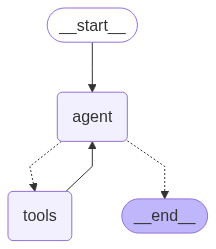

In [9]:
# 그래프 빌더 정의
from langgraph.graph import MessagesState

graph_builder = StateGraph(MessagesState)
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges('agent', tools_condition)
graph_builder.add_edge('tools', 'agent')

graph = graph_builder.compile()

graph

In [10]:
# 실행 예시
query = "https://www.youtube.com/watch?v=itJE4neqDJw 이거 댓글 리포트 만들어줘"
init_state = {"messages": [HumanMessage(content=query)]}

for chunk in graph.stream(init_state, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

https://www.youtube.com/watch?v=itJE4neqDJw 이거 댓글 리포트 만들어줘
================================== Ai Message ==================================
Tool Calls:
  get_youtube_comments_for_url (call_KC4qJGhVm2p0wyS22sH54mXw)
 Call ID: call_KC4qJGhVm2p0wyS22sH54mXw
  Args:
    youtube_url: https://www.youtube.com/watch?v=itJE4neqDJw
================================= Tool Message =================================
Name: get_youtube_comments_for_url

{"video_id": "itJE4neqDJw", "comments": ["A fresh stretch routine for you guys! ❤️ Stretching is so important for overall body health. Find time in your day to get a quick stretch on... I promise your body will thank you. Xx - Maddie", "as a 17yo I thought I didn&#39;t need to stretch since I&#39;m still young but oh my goodness, after finishing this video my body feels so much more fluid + less tight than usual, definitely going to try do this every morning!", "To anyone 

In [12]:
!pip freeze -> requirments.txt